## Comparison of the BNN and pyImfit results

In this notebook we compare the results from the Bayesian Neural Network vs Imfit using both MCMC and Bootstrap resampling of the Imfit results. 

In [6]:
#! apt-get update
#!sudo apt-get install texlive-latex-recommended 
#! sudo apt install texlive-latex-extra
#! sudo apt install dvipng
#!apt install cm-super
#!pip install chainconsumer
#!pip3 install pyimfit
#!pip install emcee

In [7]:
# Import basic packages
import numpy as np
import scipy as sp
import pandas as pd
import pylab as plt
import scipy.stats
from matplotlib.patches import Ellipse
import time

# Colab in order to download files
from google.colab import files

# Scikit-learn for scaling and preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


# PyImfit, ChainConsumer and Emcee
import pyimfit
from chainconsumer import ChainConsumer
import emcee

# Matplotlib, seaborn and plot pretty 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=9):
    

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

# Pillow
from PIL import Image

In [8]:
# Tensorflow and Keras
import tensorflow as tf
import tensorflow_probability as tfp


from tensorflow import keras 
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers
# Keras Layers
from keras.layers import InputLayer
from keras.layers import Conv2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Dense

# Import some layers etc that are useful in the Functional approach
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

In [9]:
# Mount drive to upload/download the datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Get the data

In [10]:
# Images
X_test = np.float64(np.load("/content/drive/My Drive/BNN_Final_Codes/DataSets/X_test.npy"))
# Labels
y_train = np.float64(np.load("/content/drive/My Drive/BNN_Final_Codes/DataSets/y_train.npy"))
y_test = np.float64(np.load("/content/drive/My Drive/BNN_Final_Codes/DataSets/y_test.npy"))
#Scaling
scale_test = np.float64(np.load("/content/drive/My Drive/BNN_Final_Codes/DataSets/scale_test.npy"))

**Scale the labels** 

In [11]:
scaler = StandardScaler()
# Rescale the labels
scaler.fit(y_train)
y_train_sc = scaler.transform(y_train)
y_test_sc = scaler.transform(y_test)

**Functions that convert surface brightness from counts/pixel to mag/arcsec^2 and the opposite**

In [12]:
# Converts from counts/pixel to mag/arcsec
def counts_to_SB(Counts):
  Area = (0.263)**2.0
  SB = -2.5*np.log10(Counts/Area)+30.
  return SB

# Converts from mag/arcsec to counts/pixel
def SB_to_counts(SB):
  Area = (0.263)**2.0
  exponent = (30.0-SB)/2.5
  Counts = Area*(10.0**exponent)
  return Counts

# Convert pixels to arcsec
def pix_to_asec(pix):
  asec = pix*0.263
  return asec

# Convert arcsec to pixels
def asec_to_pix(asec):
  pix = asec/0.263
  return pix

## Define BNN model 

In [13]:
# Define basic numbers
IMAGE_SHAPE = [64, 64, 1]
NUM_TRAIN_EXAMPLES = 150000
NUM_VAL_EXAMPLES = 10000
NUM_TEST_EXAMPLES = 10000
NUM_CLASSES = 5

KL divergence

In [14]:
tfd = tfp.distributions

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  # pylint: disable=g-long-lambda
                           tf.cast(NUM_TRAIN_EXAMPLES, dtype=tf.float32))

Define the model and load the model weights

In [15]:
# Bayesian DeepBFit in functional form
model_input = Input(shape=(64,64,1))
# Convolutional part =================
# 1st convolutional chunk 
x = tfp.layers.Convolution2DFlipout(
          filters = 4, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(model_input)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 2nd convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 8, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 3rd convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 16, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 4th convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 32, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)
# 5th convolutional chunk
x = tfp.layers.Convolution2DFlipout(
          filters = 64, 
          kernel_size=(3,3),
          padding='SAME',
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
x = keras.layers.MaxPool2D(pool_size=(2, 2),
                               strides=None,
                               padding='valid')(x)                    
# =========================================
# =========================================
x = keras.layers.Flatten()(x)
# =========================================
# =========================================
x = tfp.layers.DenseFlipout(
          units = 1024,
          kernel_divergence_fn=kl_divergence_function,
          activation=tf.nn.relu)(x)
#x = tfp.layers.DenseFlipout(
#          units = 512,
#          kernel_divergence_fn=kl_divergence_function,
#          activation=tf.nn.relu)(x)
distribution_params = keras.layers.Dense(tfp.layers.MultivariateNormalTriL.params_size(5))(x)
model_output = tfp.layers.MultivariateNormalTriL(event_size=5)(distribution_params)
model = Model(model_input, model_output)

/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:102: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)
/usr/local/lib/python3.7/dist-packages/tensorflow_probability/python/layers/util.py:112: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=trainable)


In [16]:
model.load_weights('/content/drive/My Drive/BNN_Final_Codes/BNN_weights.h5')

In [17]:
# Define prior limits function
def lnPrior_limits( params, imfitter ):
    """
    Defines prior-probability distributions as flat within specified limits.
    If any parameter is outside the limits, we return -np.inf; otherwise, we
    return ln(1.0) = 0 (not strictly speaking a correct probability, but it
    works for this case).

    Parameters
    ----------
    params : 1D numpy ndarray of float

    imfitter : pyimfit.Imfit instance

    Returns
    -------
    logPrior : float
    """
    parameterLimits = [[1,200],
                       [1,200],
                       [1,200],
                       [1.,180.],
                       [0.0,1.0],
                       [0.05,10.5],
                       [1,500.],
                       [1,500.]]
    if None in parameterLimits:
        raise ValueError("All parameters must have lower and upper limits.")
    nParams = len(params)
    for i in range(nParams):
        if params[i] < parameterLimits[i][0] or params[i] > parameterLimits[i][1]:
            return -np.inf
    return 0.0

In [18]:
# Define posterior
def lnPosterior_for_emcee( params, imfitter, lnPrior_func ):
    """
    Returns log of posterior probability (which is calculated as the
    product of the specified prior and the likelihood computed by the
    Imfit object using the specified parameter values).

    Parameters
    ----------
    params : 1D numpy ndarray of float
        vector of current parameter values

    imfitter : pyimfit.Imfit instance

    lnPrior_func : function or other callable
        Should compute and return log of prior probability
        signature = lnPrior_func(parameter_vector, Imfit_instance)

    Returns
    -------
    logPosterior : float
    """
    lnPrior = lnPrior_func(params, imfitter)
    if not np.isfinite(lnPrior):
        return -np.inf
    # note that Imfit.computeFitStatistic returns -2 log(likelihood)
    lnLikelihood = -0.5 *imfitter.computeFitStatistic(params)
    return lnPrior + lnLikelihood

**Select bright and faint simulated LSBGs**

In [19]:
# Bright
X_bright = X_test[y_test[:,-2]<24.5]
y_bright = y_test[y_test[:,-2]<24.5]
scale_bright = scale_test[y_test[:,-2]<24.5]

#Faint 
X_faint = X_test[y_test[:,-2]>25.2]
y_faint = y_test[y_test[:,-2]>25.2]
scale_faint = scale_test[y_test[:,-2]>25.2]

print('Number of bright:',len(y_bright))
print('Number of faint:',len(y_faint))

Number of bright: 1725
Number of faint: 2541


### **Results for Bright**

In this part we present the results for an example of a bright ($\mu > 25.2$ mag/arcsec$^2$) simulated LSBG

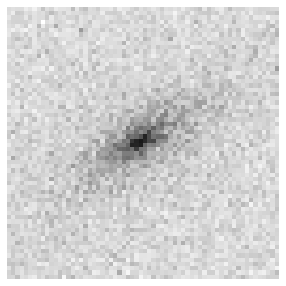

In [20]:
i = 350
X_0 = X_bright[i]
y_0 = y_bright[i]
scale_0 = scale_bright[i]
X_0_scaled = X_0*scale_0


# Make a plot 
plt.figure(figsize=(5,5))
plt.imshow(X_0.reshape(64,64),alpha=0.9,cmap='Greys')
plt.axis('off')
plt.show()

In [21]:
print(y_0)

[59.89242707  0.60387096  1.49405716 24.43896849  5.66445815]


### BNN predictions

In [22]:
n_rands = 400

tim_in = time.time() 
# Predict distribution
pred_dist = model(X_0.reshape(1,64,64,1))

# Get sample and reshape
sample_n = np.asarray(pred_dist.sample(500)).reshape(500,5)

for i in range(n_rands):
  pred_dist = model(X_0.reshape(1,64,64,1))
  sample_loc = np.asarray(pred_dist.sample(500)).reshape(500,5)
  sample_n = np.concatenate((sample_n,sample_loc))

preds_new = scaler.inverse_transform(np.asarray(sample_n))
tim_fin = time.time()
print("Time for BNN to make predict (in minutes):")
print((tim_fin-tim_in)/60.0)

Time for BNN to make predict (in minutes):
0.9731798489888509


### MCMC results

In [23]:
# CREATE AND FIT A PYIMFIT MODEL
model_im = pyimfit.SimpleModelDescription()
# define the X0,Y0 
model_im.x0.setValue(32., fixed=True)
model_im.y0.setValue(32., fixed=True)
# create a FlatSky uniform background
FlatSky_function = pyimfit.make_imfit_function("FlatSky")
FlatSky_function.I_sky.setValue(SB_to_counts(22.23), fixed=True)
# create a Sersic profile
Sersic_function = pyimfit.make_imfit_function("Sersic")
Sersic_function.PA.setValue(y_0[0])
Sersic_function.ell.setValue(y_0[1])
Sersic_function.n.setValue(y_0[2])
Sersic_function.I_e.setValue(SB_to_counts(y_0[3]))
Sersic_function.r_e.setValue(asec_to_pix(y_0[4]))

model_im.addFunction(FlatSky_function)
model_im.addFunction(Sersic_function)

# Fit and get predictions
imfit_fitter = pyimfit.Imfit(model_im)
imfit_fitter.loadData(X_0_scaled.reshape(64,64))

In [24]:
ndims, nwalkers = 8, 100
sampler = emcee.EnsembleSampler(nwalkers, ndims, lnPosterior_for_emcee, args=(imfit_fitter, lnPrior_limits))

results = imfit_fitter.doFit(getSummary=True)
p_bestfit = results.params

# Define initial positions
initial_pos = p_bestfit
# Randomize the position initialization for different walkers
initial_pos_new = [initial_pos * (1 + 0.001*np.random.randn(8)) for i in range(nwalkers)]

tim_in = time.time()
sampler.reset()
final_state = sampler.run_mcmc(initial_pos_new,3000)
tim_fin = time.time()
print("Time for MCMC sampler to run (in minutes):")
print((tim_fin-tim_in)/60.0)

# Keep converged samples and transform to physical units
converged_samples = sampler.chain[:, 1000:, :].reshape((-1, ndims))
converged_samples[:,-2] = counts_to_SB(converged_samples[:,-2])
converged_samples[:,-1] = pix_to_asec(converged_samples[:,-1])

Time for MCMC sampler to run (in minutes):
6.392969274520874


### Bootstrap resampling

In [25]:
# Here we run predictions with bootstrap resampling

nIterations = 1000

tim_in_boot = time.time()
imfit_fitter.doFit()
parameterNames, bootstrapResults = imfit_fitter.runBootstrap(nIterations, getColumnNames=True)
tim_fin_boot = time.time()
print("Time for bootstrap resampling to run (in minutes):")
print((tim_fin_boot-tim_in_boot)/60.0)

X_boot = np.copy(bootstrapResults)
Boot_chain = np.column_stack((X_boot[:,3],X_boot[:,4],X_boot[:,5],counts_to_SB(X_boot[:,6]),pix_to_asec(X_boot[:,7])))

Time for bootstrap resampling to run (in minutes):
0.8629642605781556


### Simple prediction and errors (provided by pyImfit)

In [26]:

# Fit and get predictions
imfit_fitter = pyimfit.Imfit(model_im)
imfit_fitter.loadData(X_0.reshape(64,64))

time_in_simple = time.time()
results = imfit_fitter.doFit(getSummary=True)
p_bestfit = results.params
err_bestfit = results.paramErrs
time_fin_simple = time.time()
print("Time for simple fitting (seconds):",(time_fin_simple-time_in_simple))

Time for simple fitting (seconds): 0.061878204345703125


### Plot

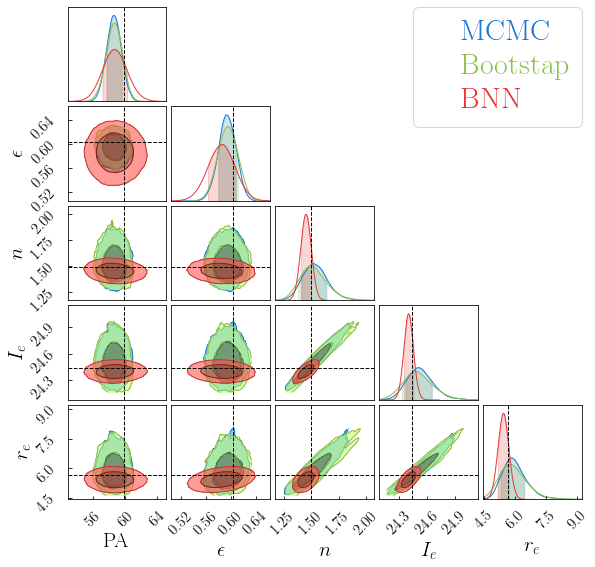

In [27]:
params = ["PA", "$\epsilon$", "$n$", "$I_e$", "$r_e$"]


c = ChainConsumer()
#c.add_chain(preds_new,parameters=params,name='BNN')
c.add_chain(converged_samples[:,3:],parameters=params,name='MCMC')
c.add_chain(Boot_chain,parameters=params,name='Bootstap')
c.add_chain(preds_new,parameters=params,name='BNN')

# Configure plot
c.configure(label_font_size=21,max_ticks=4,tick_font_size=15,
            legend_kwargs={"frameon":True, "fontsize":30}, kde=True)

fig = c.plotter.plot(figsize=(8.4,8.05), truth=y_0)
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/Results_Single_Bright.pdf",bbox_inches='tight')


### **Predictions and uncertainties**

In this sub-section we compare the predictions and uncertainties from each model.

- **BNN**

In [46]:
# Get means
means_BNN = np.mean(preds_new,axis=0)
# Get medians 
medians_BNN = np.median(preds_new,axis=0)
# Get standard deviation 
std_BNN = np.std(preds_new,axis=0)

print("Mean values:", means_BNN)
print("Median values:",medians_BNN)
print("Standard error:",std_BNN)

Mean values: [58.75401     0.58517843  1.4525176  24.42288     5.427977  ]
Median values: [58.73568    0.5853438  1.4525902 24.39989    5.427718 ]
Standard error: [1.5207905  0.02132951 0.04816069 0.05662856 0.26258823]


- **MCMC**

In [39]:
# Get means
means_MCMC = np.mean(converged_samples[:,3:],axis=0)
# Get medians 
medians_MCMC = np.median(converged_samples[:,3:],axis=0)
# Get standard deviation 
std_MCMC = np.std(converged_samples[:,3:],axis=0)

print("Mean values:", means_MCMC)
print("Median values:",medians_MCMC)
print("Standard error:",std_MCMC)

Mean values: [58.64084937  0.59430683  1.53825396 24.52508571  5.97904827]
Median values: [58.64097276  0.59432685  1.53203374 24.51651042  5.91331315]
Standard error: [0.91024031 0.01390175 0.11546184 0.14481881 0.60001595]


- **Bootsrap Resampling**

In [47]:
# Get means
means_Boot = np.mean(Boot_chain,axis=0)
# Get medians 
medians_Boot = np.median(Boot_chain,axis=0)
# Get standard deviation 
std_Boot = np.std(Boot_chain,axis=0)

print("Mean values:", means_Boot)
print("Median values:",medians_Boot)
print("Standard error:",std_Boot)

Mean values: [58.65391173  0.59528245  1.52590457 24.50543697  5.91529259]
Median values: [58.68239025  0.59550752  1.51322522 24.49004755  5.82066669]
Standard error: [0.90107885 0.01431026 0.11757486 0.15114049 0.62687782]


- **Simple max likelihood prediction**

In [57]:
#Values
bestfit_true = np.copy(p_bestfit)
bestfit_true[-1] = pix_to_asec(p_bestfit[-1])
bestfit_true[-2] = counts_to_SB(p_bestfit[-2])

#Errors
bestfit_error = np.copy(err_bestfit)
bestfit_error[-1] = pix_to_asec(err_bestfit[-1])#-pix_to_asec(p_bestfit[-1])
bestfit_error[-2] = -counts_to_SB(err_bestfit[-2]+p_bestfit[-2])+bestfit_true[-2]

print("Simple predictions:",bestfit_true[3:])
print("Bestfit errors:",bestfit_error[3:])

Simple predictions: [58.63300541  0.59507692  1.51827682 30.24499496  5.84660725]
Bestfit errors: [12.94010191  0.19192044  1.58026864  1.11705264  7.67991394]


### **Results for Faint**

In this part we present the results for an example of a faint ($\mu>25.2$ mag/arcsec$^2$)$ simulated LSBG

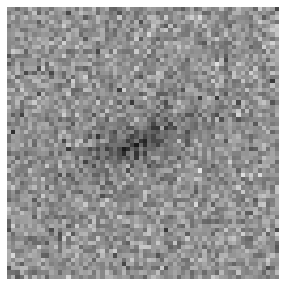

In [58]:
i = 540
X_0 = X_faint[i]
y_0 = y_faint[i]
scale_0 = scale_faint[i]
X_0_scaled = X_0*scale_0

from matplotlib import cm

norm= cm.colors.Normalize(X_bright[350].min(),X_bright[350].max())


# Make a plot 
plt.figure(figsize=(5,5))
plt.imshow(X_0.reshape(64,64),norm= norm,alpha=0.9,cmap='Greys')
plt.axis('off')
plt.show()

In [59]:
X_bright[350].min()

0.25125628140703515

In [60]:
print(y_0)

[70.18687294  0.66034666  1.10038673 25.27917277  4.80553099]


In [61]:
# CREATE AND FIT A PYIMFIT MODEL
model_im = pyimfit.SimpleModelDescription()
# define the X0,Y0 
model_im.x0.setValue(32., fixed=True)
model_im.y0.setValue(32., fixed=True)
# create a FlatSky uniform background
FlatSky_function = pyimfit.make_imfit_function("FlatSky")
FlatSky_function.I_sky.setValue(SB_to_counts(22.23), fixed=True)
# create a Sersic profile
Sersic_function = pyimfit.make_imfit_function("Sersic")
Sersic_function.PA.setValue(y_0[0])
Sersic_function.ell.setValue(y_0[1])
Sersic_function.n.setValue(y_0[2])
Sersic_function.I_e.setValue(SB_to_counts(y_0[3]))
Sersic_function.r_e.setValue(asec_to_pix(y_0[4]))

model_im.addFunction(FlatSky_function)
model_im.addFunction(Sersic_function)

# Fit and get predictions
imfit_fitter = pyimfit.Imfit(model_im)
imfit_fitter.loadData(X_0_scaled.reshape(64,64))

### BNN predictions

In [62]:
n_rands = 400

tim_in = time.time() 
# Predict distribution
pred_dist = model(X_0.reshape(1,64,64,1))

# Get sample and reshape
sample_n = np.asarray(pred_dist.sample(500)).reshape(500,5)

for i in range(n_rands):
  pred_dist = model(X_0.reshape(1,64,64,1))
  sample_loc = np.asarray(pred_dist.sample(500)).reshape(500,5)
  sample_n = np.concatenate((sample_n,sample_loc))

preds_new = scaler.inverse_transform(np.asarray(sample_n))
tim_fin = time.time()
print("Time for BNN to make predict (in minutes):")
print((tim_fin-tim_in)/60.0)

Time for BNN to make predict (in minutes):
0.9071853518486023


### MCMC results

In [63]:
ndims, nwalkers = 8, 100
sampler = emcee.EnsembleSampler(nwalkers, ndims, lnPosterior_for_emcee, args=(imfit_fitter, lnPrior_limits))

results = imfit_fitter.doFit(getSummary=True)
p_bestfit = results.params

# Define initial positions
initial_pos = p_bestfit
# Randomize the position initialization for different walkers
initial_pos_new = [initial_pos * (1 + 0.01*np.random.randn(8)) for i in range(nwalkers)]

tim_in = time.time()
sampler.reset()
final_state = sampler.run_mcmc(initial_pos_new,3000)
tim_fin = time.time()
print("Time for MCMC sampler to run (in minutes):")
print((tim_fin-tim_in)/60.0)

# Keep converged samples and transform to physical units
converged_samples = sampler.chain[:, 1000:, :].reshape((-1, ndims))
converged_samples[:,-2] = counts_to_SB(converged_samples[:,-2])
converged_samples[:,-1] = pix_to_asec(converged_samples[:,-1])

Time for MCMC sampler to run (in minutes):
6.388864759604136


### Bootstrap resampling

In [64]:
# Here we run predictions with bootstrap resampling

nIterations = 1000

tim_in_boot = time.time()
imfit_fitter.doFit()
parameterNames, bootstrapResults = imfit_fitter.runBootstrap(nIterations, getColumnNames=True)
tim_fin_boot = time.time()
print("Time for bootstrap resampling to run (in minutes):")
print((tim_fin_boot-tim_in_boot)/60.0)

X_boot = np.copy(bootstrapResults)
Boot_chain = np.column_stack((X_boot[:,3],X_boot[:,4],X_boot[:,5],counts_to_SB(X_boot[:,6]),pix_to_asec(X_boot[:,7])))

Time for bootstrap resampling to run (in minutes):
1.3641126116116842


### Plot

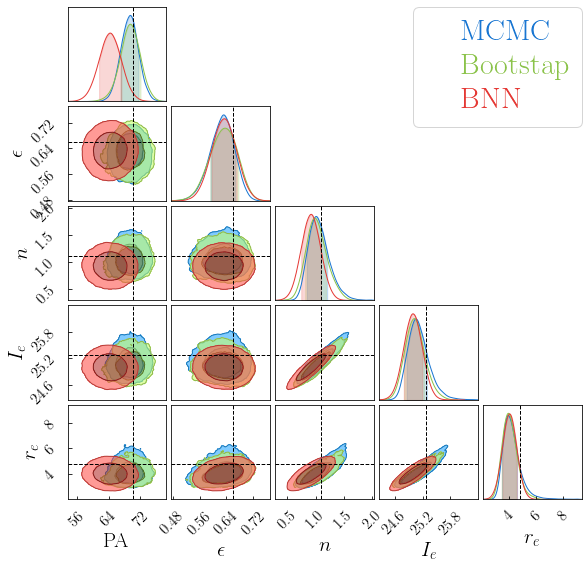

In [65]:
params = ["PA", "$\epsilon$", "$n$", "$I_e$", "$r_e$"]


c = ChainConsumer()
c.add_chain(converged_samples[:,3:],parameters=params,name='MCMC')
c.add_chain(Boot_chain[Boot_chain[:,-1]<6.5],parameters=params,name='Bootstap')
c.add_chain(preds_new,parameters=params,name='BNN')


# Configure plot
c.configure(label_font_size=21,max_ticks=4,tick_font_size=15,
            legend_kwargs={"frameon":True, "fontsize":30}, kde=True)
fig = c.plotter.plot(figsize=(8.4,8.05), truth=y_0)
plt.savefig("/content/drive/My Drive/BNN_Final_Codes/Plots/Results_Single_Faint.pdf",bbox_inches='tight')

### Simple prediction and error

In [69]:

# Fit and get predictions
imfit_fitter = pyimfit.Imfit(model_im)
imfit_fitter.loadData(X_0.reshape(64,64))

time_in_simple = time.time()
results = imfit_fitter.doFit(getSummary=True)
p_bestfit = results.params
err_bestfit = results.paramErrs
time_fin_simple = time.time()
print("Time for simple fitting (seconds):",(time_fin_simple-time_in_simple))

Time for simple fitting (seconds): 0.5948505401611328


### **Predictions and uncertainties**

In this sub-section we compare the predictions and uncertainties from each model, for the faint galaxy example.

- **BNN**

In [66]:
# Get means
means_BNN = np.mean(preds_new,axis=0)
# Get medians 
medians_BNN = np.median(preds_new,axis=0)
# Get standard deviation 
std_BNN = np.std(preds_new,axis=0)

print("Mean values:", means_BNN)
print("Median values:",medians_BNN)
print("Standard error:",std_BNN)

Mean values: [64.40621     0.6328725   0.92083466 24.99442     4.0372286 ]
Median values: [64.41574     0.63310844  0.92070687 24.994204    4.0353394 ]
Standard error: [2.793734   0.03730447 0.17081662 0.19893661 0.53401697]


- **MCMC**

In [67]:
# Get means
means_MCMC = np.mean(converged_samples[:,3:],axis=0)
# Get medians 
medians_MCMC = np.median(converged_samples[:,3:],axis=0)
# Get standard deviation 
std_MCMC = np.std(converged_samples[:,3:],axis=0)

print("Mean values:", means_MCMC)
print("Median values:",medians_MCMC)
print("Standard error:",std_MCMC)

Mean values: [69.30962067  0.62667585  1.06889375 25.12175764  4.21518124]
Median values: [69.32934543  0.62868069  1.0467475  25.09536458  4.09896426]
Standard error: [2.23468433 0.03675881 0.18945602 0.23549129 0.69485906]


- **Bootstrap resampling**

In [68]:
# Get means
means_Boot = np.mean(Boot_chain,axis=0)
# Get medians 
medians_Boot = np.median(Boot_chain,axis=0)
# Get standard deviation 
std_Boot = np.std(Boot_chain,axis=0)

print("Mean values:", means_Boot)
print("Median values:",medians_Boot)
print("Standard error:",std_Boot)

Mean values: [69.43561975  0.63100832  1.02509817 25.04476839  4.06299278]
Median values: [69.53204318  0.6322387   1.00800414 25.03443498  4.00163163]
Standard error: [2.29965519 0.03728601 0.16894444 0.19946989 0.52252677]


- **Simple max likelinhood prediction** 

In [70]:
#Values
bestfit_true = np.copy(p_bestfit)
bestfit_true[-1] = pix_to_asec(p_bestfit[-1])
bestfit_true[-2] = counts_to_SB(p_bestfit[-2])

#Errors
bestfit_error = np.copy(err_bestfit)
bestfit_error[-1] = pix_to_asec(err_bestfit[-1])#-pix_to_asec(p_bestfit[-1])
bestfit_error[-2] = -counts_to_SB(err_bestfit[-2]+p_bestfit[-2])+bestfit_true[-2]

print("Simple predictions:",bestfit_true[3:])
print("Bestfit errors:",bestfit_error[3:])

Simple predictions: [69.34496271  0.63269995  1.01191463 30.34759076  3.98144048]
Bestfit errors: [25.86934557  0.39440785  1.92360001  1.24497144  5.91957007]
